Каждый пункт, который предлагается выполнить в рамках домашнего задания, имеет объявленную "цену" в баллах. Максимально возможная сумма – 10 баллов, а с учётом бонусных пунктов – 12 баллов. Выполнять все пункты не обязательно, можно сделать только часть. В большинстве пунктов ожидается, что вы напишете работающий код на Python; иногда надо будет писать комментарии в свободной форме – например, сравнивать несколько подходов к решению одной задачи. Там, где оставлены пустые клетки под ваши ответы, вы можете по своему усмотрению добавлять ещё клетки.

* * *

Эта лабораторная работа посвящена кластеризации. Мы будем работать с рукописными изображениями цифр, научимся их кластеризовать двумя разными методами (иерархическая кластеризация и алгоритм $K$-means), оценивать качество разбиения и выбирать оптимальное число кластеров, а также визуализировать промежуточные результаты.

# 1. Получение данных

Данные, с которыми мы будем работать, доступны в библиотеке scikit-learn (модуль называется `sklearn`) в подмодуле `datasets` через функцию, которая называется `load_digits`. Всего имеется 1797 наблюдений, каждое из них представляет чёрно-белую картинку 8 $\times$ 8 пикселей. Эти картинки – распознанные рукописные цифры от 0 до 9. Образцов написания каждой цифры дано приблизительно поровну, около 180.

Для удобства использования данных каждая картинка "развёрнута" в строку, так что NumPy-массив, в котором хранятся данные, имеет размерность 2 и величину 1797 $\times$ 64 (а не, например, размерность 3 и величину 1797 $\times$ 8 $\times$ 8). Интенсивность цвета в каждом пикселе кодируется целым числом от 0 до 16.

Кроме наблюдений (картинок), известны соответствующие им значения целевой переменной: какую цифру на самом деле изображает каждая картинка. Мы могли бы сразу сформулировать задачу обучения с учителем и предсказывать цифры по картинкам, но для целей этой лабораторной работы мы будем действовать по-другому: сделаем вид, что нам не известны истинные метки классов (т. е. цифры) и даже количество классов, и попробуем сгруппировать данные таким образом, чтобы качество кластеризации оказалось наилучшим, а затем посмотрим, насколько точно полученные кластеры совпадают с группами изображений одинаковых цифр.

**(0.5 балла)** Загрузите данные. Добейтесь, чтобы в переменной `X` оказался массив наблюдений, содержащий 1797 $\times$ 64 числа, а в переменной `y` – массив истинных меток классов, содержащий 1797 чисел.

*Указания:*
- Как загрузить данные, объяснено в справке к функции `load_digits`.
- Размер массива хранится в атрибуте `shape`.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn import datasets

In [3]:
X, y = datasets.load_digits(return_X_y=True)
print(' Размерность X = ', X.shape, '\n', 'Размерность у = ', y.shape)

 Размерность X =  (1797, 64) 
 Размерность у =  (1797,)


**(1 балл)** Визуализируйте первые десять картинок, расположив их на сетке 3 $\times$ 4 (в последнем ряду останутся пустые места). Добейтесь, чтобы фон картинок был белым, а изображения цифр – тёмными.

*Указания:*
- Не забудьте импортировать NumPy и Matplotlib.
- Картинки 8 $\times$ 8 можно либо достать готовыми из объекта, загруженного функцией `load_digits`, либо сделать самостоятельно из строк массива `X`. Во втором случае пользуйтесь методом `reshape`.
- Чтобы изображение не было цветным, можно вызвать функцию `plt.gray`, прежде чем начать рисовать.
- Располагать картинки на сетке умеет функция `plt.subplot`. Ознакомьтесь со справкой к ней.
- По умолчанию число 0 кодирует чёрный цвет, а число 16 – белый цвет. Подумайте, как обратить цвета одной операцией над NumPy-массивом.
- Выводить картинку на экран умеет функция `plt.imshow`. Ознакомьтесь со справкой к ней.
- Если считаете нужным, можете отключить сглаживание – параметр `interpolation` у функции `plt.imshow`.
- Если считаете нужным, можете отключить деления на координатных осях. За это отвечают функции `plt.xticks` и `plt.yticks`.

In [4]:
import numpy as np
import matplotlib.pyplot as plt

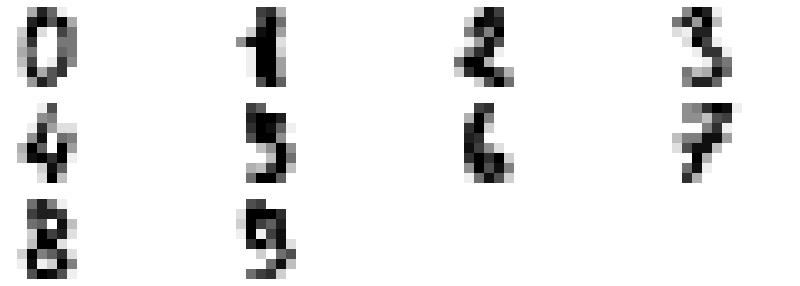

In [5]:
_, axes = plt.subplots(nrows = 3, ncols = 4, figsize=(15, 5))
n = 0
for ax, image in zip(axes.flatten(), X):
    if n < 10: 
        ax.set_axis_off()
        ax.imshow(image.reshape((8, 8)), cmap = plt.cm.gray_r)
        n += 1
    else:
        ax.set_axis_off()

# 2. Кластеризация и оценка качества

Мы будем использовать два популярных алгоритма: иерархическую кластеризацию и метод $K$ средних ($K$-means clustering). Эти и другие алгоритмы кластеризации доступны в библиотеке scikit-learn в подмодуле `cluster`. Иерархическая кластеризация называется `AgglomerativeClustering`, а метод $K$ средних – `KMeans`.

Интерфейс у большинства алгоритмов в scikit-learn простой и единообразный:
- Чтобы инициализировать модель, нужно создать экземпляр соответствующего класса со всеми необходимыми параметрами. Например, у кластеризаций единственный обязательный параметр называется `n_clusters`, это количество кластеров, которое мы хотим получить на выходе.
- Инициализированную модель можно обучить, вызвав метод `fit`.
- С помощью обученной модели можно предсказывать, вызывая метод `predict`.

Как видно, этот интерфейс хорош только для задач обучения с учителем, в которых чётко разделены фазы обучения модели и предсказания с её помощью. У кластеризаций зато есть метод `fit_predict`, который разбивает входную выборку на кластеры и сразу же возвращает результаты разбиения.

**(0.5 балла)** Используя каждый из двух методов, иерархическую кластеризацию и $K$ средних, получите разбиение массива `X` на 10 кластеров.

*Указания:*
- Оба раза должен получиться массив из 1797 чисел – номеров кластеров.
- `KMeans` делает несколько (по умолчанию 10) запусков со случайными центрами и из полученных разбиений выводит лучшее в терминах среднего внутрикластерного расстояния. Чтобы улучшить качество предсказаний, можно увеличить число запусков, например, до 100. Это параметр `n_init` в конструкторе.

In [6]:
from sklearn.cluster import AgglomerativeClustering, KMeans

In [7]:
from sklearn.cluster import AgglomerativeClustering, KMeans

# Иерархическая кластеризация.
aggclust = AgglomerativeClustering(n_clusters = 10)
clusters_AC = aggclust.fit_predict(X)
print(clusters_AC.shape)

(1797,)


In [8]:
# К-средних.
kmeans = KMeans(n_clusters = 10, n_init = 100)
clusters_KM = kmeans.fit_predict(X)
print(clusters_KM.shape)

(1797,)


**(1 балл)** Визуализируйте центры кластеров, полученных каждым из двух способов. Это опять должны быть картинки на сетке 3 $\times$ 4 с белым фоном и тёмными контурами. Прокомментируйте: какой из двух алгоритмов даёт центры кластеров, больше похожие на типичные начертания цифр?

*Указания:*
- Центр кластера – это среднее по всем наблюдениям, входящим в кластер, т. е. по какому-то набору строк из `X`.
- Чтобы выбрать наблюдения, входящие в кластер номер `i`, используйте индексацию по булевозначной маске. Саму маску можно получить из массива предсказанных номеров кластеров и числа `i` оператором `==`.
- Усреднять NumPy-массив вдоль какой-нибудь из осей умеет функция `np.mean`. Ознакомьтесь со справкой к ней. Нам нужно усреднение по строкам.

In [9]:
param_no = {"axes.spines.left" : False,
      "axes.spines.right" : False,
      "axes.spines.bottom" : False,
      "axes.spines.top" : False,
      "xtick.bottom" : False,
      "xtick.labelbottom" : False,
      "ytick.labelleft" : False,
      "ytick.left" : False}
plt.rcParams.update(param_no)

In [10]:
# Поиск центров классов.
def centres(clusters, x):
    for i in range(10):
        n = 0
        c = np.zeros(x.shape[1])
        for j in range(len(clusters)):
            if clusters[j] == i:
                c = c + x[j]
                n += 1
        if i == 0:
            centers = c / n
        else:
            centers = np.vstack([centers, (c/n)])
    return centers

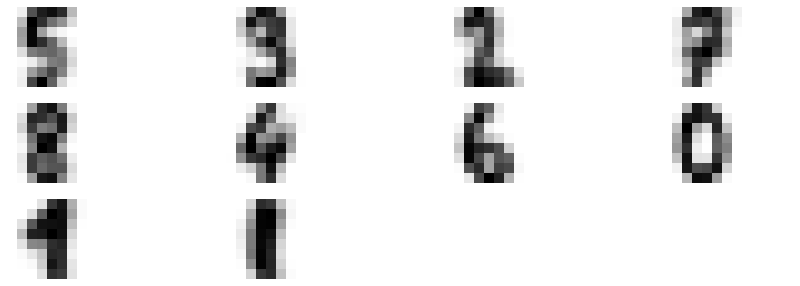

In [11]:
centers_AC = centres(clusters_AC, X)

# Визуализация для иерархической кластеризации.

fig, ax = plt.subplots(3, 4, figsize = (15, 5))
for ax, center in zip(ax.flat, centers_AC):
    ax.set_axis_off()
    ax.imshow(center.reshape(8, 8),  cmap = plt.cm.gray_r)

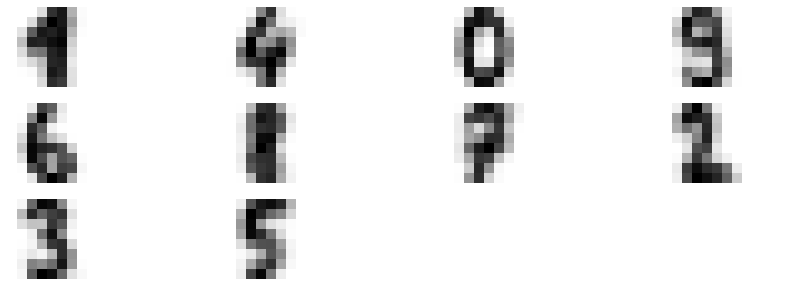

In [12]:
centers_KM = centres(clusters_KM, X)

#Визуализация для К-средних.

fig, ax = plt.subplots(3, 4, figsize = (15, 5))
for ax, center in zip(ax.flat, centers_KM):
    ax.set_axis_off()
    ax.imshow(center.reshape(8, 8), cmap = plt.cm.gray_r)

В ситуации, когда истинное число кластеров неизвестно, подбирают оптимальное число кластеров. При этом учитывают две величины: внутрикластерное расстояние (чем меньше, тем лучше) и межкластерное расстояние (чем больше, тем лучше). Так как две эти величины не достигают оптимума одновременно, обычно оптимизируют какой-нибудь функционал от них. Один популярный функционал называется "силуэт" (silhouette). Вот как он вычисляется.

Пусть $X$ – множество наблюдений, $M \subset X$ – один из кластеров, на которые оно разбито в результате кластеризации, $\rho$ – метрика на $X$. Выберем какое-нибудь одно наблюдение $x \in M$. Обозначим $a(x)$ среднее расстояние от $x$ до точек $x'$ из того же кластера:
$$
a(x) = \frac{1}{|M| - 1} \sum_{x' \in M,\, x' \ne x} \rho(x,\, x')
$$

Обозначим $b(x)$ минимум средних расстояний от $x$ до точек $x''$ из какого-нибудь другого кластера $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

Силуэт – это разность межкластерного и внутрикластерного расстояний, нормированная до отрезка $[-1,\, 1]$ и усреднённая по всем наблюдениям:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

В scikit-learn силуэт считается функцией `silhouette_score` из подмодуля `metrics`. На вход нужно передать массив наблюдений и результат кластеризации.

**(1.5 балла)** Для числа $K$ от 2 до 20 включительно получите разбиение массива `X` на $K$ кластеров каждым из двух методов. Посчитайте силуэт. Посчитанные значения силуэта сохраните в переменную и визуализируйте в виде графика в координатах: число $K$ – значение силуэта. При каком числе кластеров достигается максимум силуэта?

*Указания:*
- Не забудьте, что функция `range` не захватывает правый конец диапазона.
- Под значения силуэта можно завести два списка: один для иерархической кластеризации, другой для $K$ средних.
- Рисовать графики умеет функция `plt.plot`. Ознакомьтесь со справкой к ней.
- На одной картинке можно разместить несколько графиков, это просто несколько последовательных вызовов `plt.plot`.
- Чтобы добавить легенду (подписи к графикам), можно воспользоваться функцией `plt.legend`. Местоположение легенды контролируется параметром `loc`.
- Чтобы подписать координатные оси, можно воспользоваться функциями `plt.xlabel` и `plt.ylabel`.

In [13]:
from sklearn.metrics import silhouette_score

In [14]:
score_AC, score_KM, K = [], [], []
score_AC_max, score_KM_max = 0, 0
for n_clusters in range(2, 21):

    aggclust = AgglomerativeClustering(n_clusters = n_clusters)
    clusters_AC = aggclust.fit_predict(X)
    score_AC.append(silhouette_score(X, clusters_AC))
        
    kmeans = KMeans(n_clusters = n_clusters, n_init = 100)
    clusters_KM = kmeans.fit_predict(X)
    score_KM.append(silhouette_score(X, clusters_KM))
    
    # Поиск максимума силуэта.
    if score_AC_max < silhouette_score(X, clusters_AC):
        score_AC_max = silhouette_score(X, clusters_AC)
        n_clusters_AC_max = n_clusters
        
    if score_KM_max < silhouette_score(X, clusters_KM):
        score_KM_max = silhouette_score(X, clusters_KM)
        n_clusters_KM_max = n_clusters
    
    K.append(n_clusters)
    
print('Максисум силуэта при иерархической кластеризации = ', score_AC_max, 'при числе кластеров = ', n_clusters_AC_max)
print('Максисум силуэта при К-средних = ', score_KM_max, 'при числе кластеров = ', n_clusters_KM_max)

Максисум силуэта при иерархической кластеризации =  0.18061975703867697 при числе кластеров =  9
Максисум силуэта при К-средних =  0.1905317204788502 при числе кластеров =  17


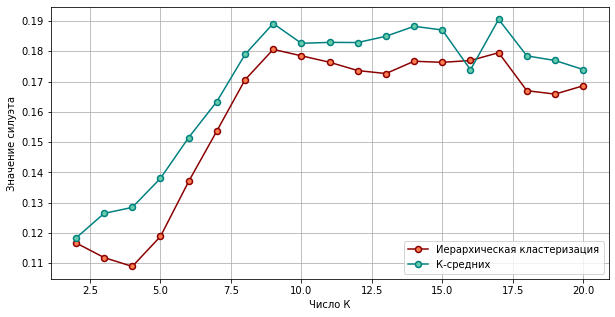

In [15]:
param_yes = {"axes.spines.left" : True,
      "axes.spines.right" : True,
      "axes.spines.bottom" : True,
      "axes.spines.top" : True,
      "xtick.bottom" : True,
      "xtick.labelbottom" : True,
      "ytick.labelleft" : True,
      "ytick.left" : True}
plt.rcParams.update(param_yes)

fig, ax = plt.subplots(figsize=(10,5))
plt.plot(K, score_AC, label = "Иерархическая кластеризация", marker='o', c='darkred', markerfacecolor = 'coral',
         markeredgecolor = 'darkred', markeredgewidth = 1.5)
plt.plot(K, score_KM, label = "К-средних", marker='o', c='teal', markerfacecolor = 'mediumaquamarine', 
         markeredgecolor = 'teal', markeredgewidth = 1.5)
ax.set_ylabel('Значение силуэта')
ax.set_xlabel('Число К')
ax.grid()
plt.legend()

Когда известно "правильное" (в каком-нибудь смысле) разбиение на кластеры, результат кластеризации можно сравнить с ним, используя такие меры, как однородность (homogeneity), полнота (completeness) и их среднее гармоническое – $V$-мера. Определения этих величин довольно громоздкие и основаны на понятии [энтропии распределения вероятностей](https://ru.wikipedia.org/wiki/Информационная_энтропия); подробности излагаются в [этой статье](http://aclweb.org/anthology/D/D07/D07-1043.pdf). На практике достаточно знать, что однородность, полнота и $V$-мера заключены между нулём и единицей – чем больше, тем лучше.

Так как мы знаем, какую цифру на самом деле изображает каждая картинка (это массив `y`), мы можем использовать однородность, полноту и $V$-меру для оценки качества кластеризации. Функции для вычисления этих величин доступны в scikit-learn, в подмодуле `metrics`, под названиями `homogeneity_score`, `completeness_score`, `v_measure_score`. Как вариант, можно использовать функцию `homogeneity_completeness_v_measure`, которая возвращает сразу тройку чисел.

**(1 балл)** Повторите предыдущее задание, используя $V$-меру вместо силуэта. При каком числе кластеров достигается максимум $V$-меры?

In [16]:
from sklearn.metrics import v_measure_score

In [17]:
v_score_AC, v_score_KM, K = [], [], []
v_score_AC_max, v_score_KM_max = 0, 0
for n_clusters in range(2, 21):

    aggclust = AgglomerativeClustering(n_clusters = n_clusters)
    clusters_AC = aggclust.fit_predict(X)
    v_score_AC.append(v_measure_score(y, clusters_AC))
        
    kmeans = KMeans(n_clusters = n_clusters, n_init = 100)
    clusters_KM = kmeans.fit_predict(X)
    v_score_KM.append(v_measure_score(y, clusters_KM))
    
    # Поиск максимума v_меры.
    if v_score_AC_max < v_measure_score(y, clusters_AC):
        v_score_AC_max = v_measure_score(y, clusters_AC)
        n_clusters_AC_max = n_clusters
        
    if v_score_KM_max < v_measure_score(y, clusters_KM):
        v_score_KM_max = v_measure_score(y, clusters_KM)
        n_clusters_KM_max = n_clusters
    
    K.append(n_clusters)
    
print('Максисум V-меры при иерархической кластеризации = ', v_score_AC_max, 'при числе кластеров = ', n_clusters_AC_max)
print('Максисум V-меры при К-средних = ', v_score_KM_max, 'при числе кластеров = ', n_clusters_KM_max)

Максисум V-меры при иерархической кластеризации =  0.86854875186737 при числе кластеров =  12
Максисум V-меры при К-средних =  0.7909844802719719 при числе кластеров =  16


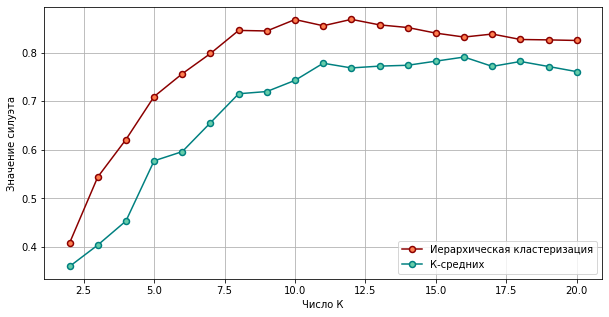

In [18]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(K, v_score_AC, label = "Иерархическая кластеризация", marker='o', c='darkred', markerfacecolor = 'coral',
         markeredgecolor = 'darkred', markeredgewidth = 1.5)
plt.plot(K, v_score_KM, label = "К-средних", marker='o', c='teal', markerfacecolor = 'mediumaquamarine', 
         markeredgecolor = 'teal', markeredgewidth = 1.5)
ax.set_ylabel('Значение силуэта')
ax.set_xlabel('Число К')
ax.grid()
plt.legend()

# 3. Снижение размерности признакового пространства

Иногда, особенно когда признаков много и не все они одинаково информативные, бывает полезно снизить размерность признакового пространства, то есть вместо $d$ исходных признаков перейти к рассмотрению $d' \ll d$ новых признаков. Данные были представлены матрицей $n$ наблюдений $\times$ $d$ исходных признаков, а теперь будут представлены матрицей $n$ наблюдений $\times$ $d'$ новых признаков.

Есть два популярных подхода к снижению размерности:
- отобрать (select) новые признаки из числа имеющихся;
- извлечь (extract) новые признаки, преобразуя старые, например, сделать $d'$ различных линейных комбинаций столбцов исходной матрицы $n \times d$.

Одним из широко используемых методов извлечения признаков является сингулярное разложение матрицы (singular value decomposition, SVD). Этот метод позволяет сконструировать любое число $d' \le d$ новых признаков таким образом, что они будут, в определённом смысле, максимально информативными. Математические детали сейчас не важны; познакомиться с ними можно, например, [здесь](https://www.coursera.org/learn/mathematics-and-python/lecture/L9bCV/razlozhieniia-matrits-v-proizviedieniie-singhuliarnoie-razlozhieniie)
(по-русски) или [здесь](https://www.youtube.com/watch?v=P5mlg91as1c) (по-английски).

В scikit-learn есть несколько реализаций сингулярного разложения. Мы будем использовать класс `TruncatedSVD` из подмодуля `decomposition`. В конструктор этого класса достаточно передать один параметр `n_components` – желаемое число новых признаков. Метод `fit_transform` принимает матрицу и возвращает новую матрицу с таким же количеством строк, как прежде, и количеством столбцов, равным числу новых признаков.

<u>Замечание:</u> Сингулярное разложение матрицы $M$ обычно пишут в виде $M = U \Sigma V^{*}$, где $U$, $\Sigma$ и $V$ – некие матрицы с хорошими свойствами. То, что возвращает алгоритм `TruncatedSVD`, – это сколько-то (сколько мы хотим получить) первых столбцов матрицы $U$.

**(1.5 балла)** Выполните сингулярное разложение матрицы `X`, оставляя 2, 5, 10, 20 признаков. В каждом случае выполните иерархическую и $K$-means кластеризацию преобразованных данных (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли при каком-нибудь $d'$ получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [19]:
from sklearn.decomposition import TruncatedSVD

In [20]:
aggclust = AgglomerativeClustering(n_clusters = 10)
clusters_AC = aggclust.fit_predict(X)
d_ss_AC, d_vs_AC = 64, 64
silhouette_score_AC_max = silhouette_score(X, clusters_AC)
v_score_AC_max = v_measure_score(y, clusters_AC)

kmeans = KMeans(n_clusters = 10, n_init = 100)
clusters_KM = kmeans.fit_predict(X)
d_ss_KM, d_vs_KM = 64, 64
silhouette_score_KM_max = silhouette_score(X, clusters_KM)
v_score_KM_max = v_measure_score(y, clusters_KM)

In [21]:
for n_components in (2, 5, 10, 20):
    T_svd = TruncatedSVD(n_components = n_components, random_state = 20)
    X_new = T_svd.fit_transform(X)
    # Иерархическая кластеризация
    aggclust = AgglomerativeClustering(n_clusters = 10)
    clusters_AC = aggclust.fit_predict(X_new)
        
    if silhouette_score_AC_max < silhouette_score(X_new, clusters_AC):
        silhouette_score_AC_max = silhouette_score(X_new, clusters_AC)
        d_ss_AC = n_components
        
    if v_score_AC_max < v_measure_score(y, clusters_AC):
        v_score_AC_max = v_measure_score(y, clusters_AC)
        d_vs_AC = n_components
        
    # К-средних
    kmeans = KMeans(n_clusters = 10, n_init = 100)
    clusters_KM = kmeans.fit_predict(X_new)
    
    if silhouette_score_KM_max < silhouette_score(X_new, clusters_KM):
        silhouette_score_KM_max = silhouette_score(X_new, clusters_KM)
        d_ss_KM = n_components
        
    if v_score_KM_max < v_measure_score(y, clusters_KM):
        v_score_KM_max = v_measure_score(y, clusters_KM)
        d_vs_KM = n_components
V_measure_score_AC_svd = v_score_AC_max
V_measure_score_KM_svd = v_score_KM_max
print('Максисум силуэта при иерархической кластеризации = ', silhouette_score_AC_max, 'достигается при количестве признаков ' , d_ss_AC, ' .')
print('Максисум V-меры при иерархической кластеризации = ', v_score_AC_max, 'достигается при количестве признаков ' , d_vs_AC, '.')
print('Максисум силуэта при К-средних = ', silhouette_score_KM_max, 'достигается при количестве признаков ' , d_ss_KM, ' .')
print('Максисум V-меры при К-средних = ', v_score_KM_max, 'достигается при количестве признаков ' , d_vs_KM, '.')

Максисум силуэта при иерархической кластеризации =  0.28081683997204043 достигается при количестве признаков  2  .
Максисум V-меры при иерархической кластеризации =  0.8681701126909083 достигается при количестве признаков  64 .
Максисум силуэта при К-средних =  0.34917964883368585 достигается при количестве признаков  2  .
Максисум V-меры при К-средних =  0.7428159056017571 достигается при количестве признаков  64 .


Другая популярная техника снижения размерности, которая особенно хорошо подходит для работы с картинками, – это алгоритм t-distributed stochastic neighbor embeddings, сокращённо tSNE. В отличие от сингулярного разложения, это преобразование нелинейное. Его основная идея – отобразить точки из пространства размерности $d$ в пространство размерности 2 или 3 (обычно 2, то есть на плоскость) таким образом, чтобы как можно точнее сохранить расстояния. Математические детали есть, например, [здесь](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), но они нетривиальны.

В библиотеке scikit-learn реализацией tSNE является класс `TSNE` в подмодуле `manifold`. В конструктор можно передать параметр `n_components`, а можно и не передавать: по умолчанию он равен 2. Метод `fit_transform` работает аналогично тому, как и у `TruncatedSVD`.

<u>Замечание:</u> В последние годы вместо tSNE на практике часто используется [UMAP](https://github.com/lmcinnes/umap), более быстрый алгоритм с похожими свойствами. В этой лабораторной работе не предлагается использовать UMAP, так как это потребовало бы установить ещё одну зависимость -- библиотеку `umap-learn`. Желающие могут проделать задания на tSNE с использованием UMAP; в этом случае обратите внимание на параметры `n_neighbors` и `min_dist`, которыми определяется вид проекции.

**(0.5 балла)** Выполните tSNE-преобразование матрицы `X`, оставив 2 признака. Визуализируйте данные, преобразованные таким образом, в виде точечной диаграммы: первый признак вдоль горизонтальной оси, второй признак вдоль вертикальной оси. Подсветите разными цветами группы точек, соответствующих разным цифрам.

*Указания:*
- Точечную диаграмму умеет рисовать функция `plt.scatter`. Ознакомьтесь со справкой к ней.
- За цвета точек отвечает параметр `c` у функции `plt.scatter`. Передать в него надо истинные метки классов.

In [22]:
from sklearn.manifold import TSNE

In [23]:
X_tsne = TSNE(n_components = 2, random_state = 20).fit_transform(X)

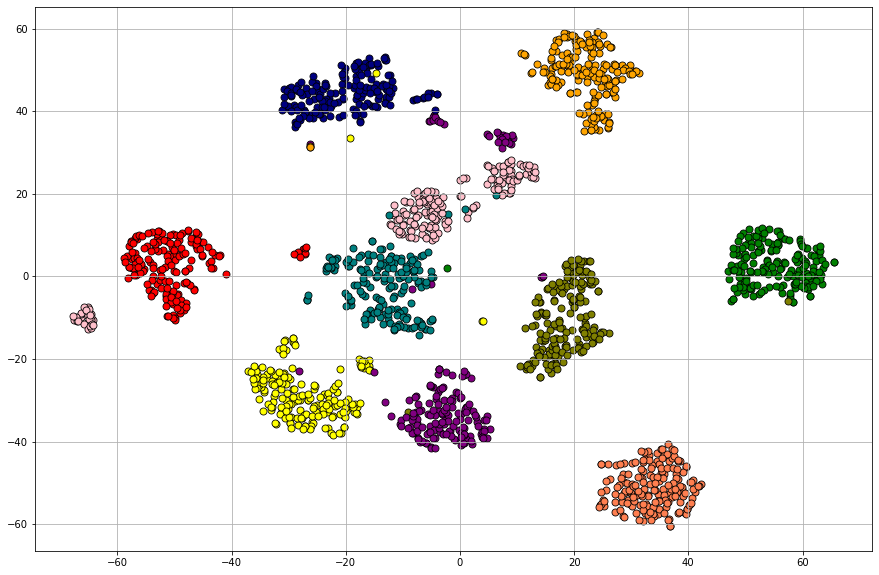

In [24]:
fig, ax = plt.subplots(figsize=(15,10))
j = 0
c = {0: 'coral', 1: 'pink', 2: 'red', 3: 'yellow', 4: 'orange', 5: 'olive', 6: 'green', 7: 'navy', 8: 'teal', 9: 'purple'}
for i in y:
    plt.scatter(X_tsne[j, 0], X_tsne[j, 1], marker='o', c = c[i], s = 50, linewidths = 0.8, edgecolors = 'black') 
    j += 1
ax.grid()
plt.show()

**(1 балл)** Для tSNE-преобразованных данных с 2 признаками выполните иерархическую и $K$-means кластеризацию (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [25]:
aggclust = AgglomerativeClustering(n_clusters = 10)
clusters_AC = aggclust.fit_predict(X)
silhouette_score_AC_max = silhouette_score(X, clusters_AC)
v_score_AC_max = v_measure_score(y, clusters_AC)

kmeans = KMeans(n_clusters = 10, n_init = 100)
clusters_KM = kmeans.fit_predict(X)
silhouette_score_KM_max = silhouette_score(X, clusters_KM)
v_score_KM_max = v_measure_score(y, clusters_KM)

In [26]:
X_tsne = TSNE(n_components = 2, random_state = 20).fit_transform(X)
d__ss_AC, d__vs_AC, d__ss_KM, d__vs_KM = 64, 64, 64, 64
# Иерархическая кластеризация
aggclust = AgglomerativeClustering(n_clusters = 10)
clusters_AC = aggclust.fit_predict(X_tsne)
        
if silhouette_score_AC_max < silhouette_score(X_tsne, clusters_AC):
    silhouette_score_AC_max = silhouette_score(X_tsne, clusters_AC)
    d__ss_AC = 2
    print('Максисум силуэта при иерархической кластеризации(', silhouette_score_AC_max, ') достигается при исспользовании преобразованных данных')
else:
    print('Максисум силуэта при иерархической кластеризации(', silhouette_score_AC_max, ') достигается при исспользовании исходных данных')

if v_score_AC_max < v_measure_score(y, clusters_AC):
    v_score_AC_max = v_measure_score(y, clusters_AC)
    d__vs_AC = 2    
    print('Максисум V-меры при иерархической кластеризации(', v_score_AC_max, ') достигается при исспользовании преобразованных данных')
else:
    print('Максисум V-меры при иерархической кластеризации(', v_score_AC_max, ') достигается при исспользовании исходных данных')

# К-средних
kmeans = KMeans(n_clusters = 10, n_init = 100)
clusters_KM = kmeans.fit_predict(X_tsne)
    
if silhouette_score_KM_max < silhouette_score(X_tsne, clusters_KM):
    silhouette_score_KM_max = silhouette_score(X_tsne, clusters_KM)
    d__ss_KM = 2
    print('Максисум силуэта при К-средних(', silhouette_score_KM_max, ') достигается при исспользовании преобразованных данных')   
else:
    print('Максисум силуэта при иерархической кластеризации(', silhouette_score_KM_max, ') достигается при исспользовании исходных данных')

if v_score_KM_max < v_measure_score(y, clusters_KM):
    v_score_KM_max = v_measure_score(y, clusters_KM)
    d__vs_KM = 2
    print('Максисум V-меры при К-средних(', v_score_KM_max, ') достигается при исспользовании преобразованных данных')
else:
    print('Максисум V-меры при иерархической кластеризации(', v_score_KM_max, ') достигается при исспользовании исходных данных')
V_measure_score_AC_tsne = v_score_AC_max
V_measure_score_KM_tsne = v_score_KM_max

Максисум силуэта при иерархической кластеризации( 0.64426076 ) достигается при исспользовании преобразованных данных
Максисум V-меры при иерархической кластеризации( 0.9110554140916143 ) достигается при исспользовании преобразованных данных
Максисум силуэта при К-средних( 0.6459219 ) достигается при исспользовании преобразованных данных
Максисум V-меры при К-средних( 0.9098072147388365 ) достигается при исспользовании преобразованных данных


**(0.5 балла)** Для самого лучшего разбиения, которое вам удалось получить (на ваше усмотрение, лучшего в терминах силуэта или $V$-меры), опять визуализируйте картинками центры кластеров. Удалось ли добиться, чтобы каждый кластер соответствовал какой-нибудь одной цифре?

In [27]:
plt.rcParams.update(param_no)

V_мера = 0.9110554140916143


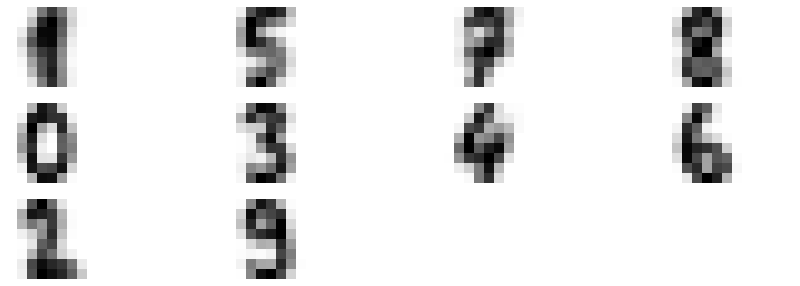

In [28]:
# Визуализация лучшей модели для иерархической кластеризации.
# Количество классов n_clusters = 10
# Количество признаков n_components:
if V_measure_score_AC_svd > V_measure_score_AC_tsne:
    if  d_vs_AC < 64:
        T_svd = TruncatedSVD(n_components = d_vs_AC, random_state = 20)
        X_best = T_svd.fit_transform(X)
    else:
        X_best = X
else:
    if  d__vs_AC < 64:
        X_best = TSNE(n_components = d__vs_AC, random_state = 20).fit_transform(X)
    else:
        X_best = X
    
aggclust = AgglomerativeClustering(n_clusters = 10)
clusters_AC = aggclust.fit_predict(X_best)
print('V_мера =', v_measure_score(y, clusters_AC))

centers_AC = centres(clusters_AC, X)

fig, ax = plt.subplots(3, 4, figsize = (15, 5))
for ax, center in zip(ax.flat, centers_AC):
    ax.set_axis_off()
    ax.imshow(center.reshape(8, 8),  cmap = plt.cm.gray_r)

V_мера = 0.9098072147388365


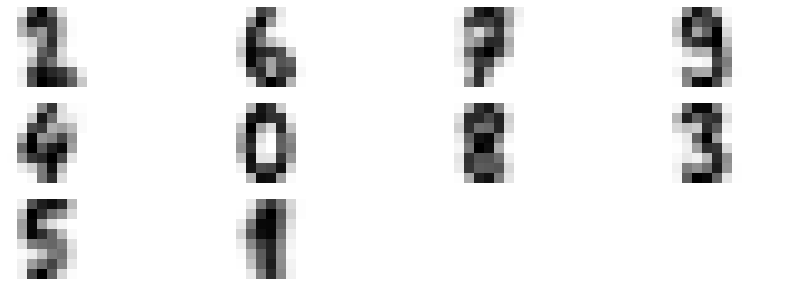

In [29]:
#Визуализация лучшей модели для К-средних.
# Количество классов n_clusters = 10
# Количество признаков n_components:
if V_measure_score_KM_svd > V_measure_score_KM_tsne:
    if  d_vs_KM < 64:
        T_svd = TruncatedSVD(n_components = d_vs_KM, random_state = 20)
        X_best = T_svd.fit_transform(X)
    else:
        X_best = X
else:
    if  d__vs_KM < 64:
        X_best = TSNE(n_components = d__vs_KM, random_state = 20).fit_transform(X)
    else:
        X_best = X
    
kmeans = KMeans(n_clusters = 10, n_init = 100)
clusters_KM = kmeans.fit_predict(X_best)
print('V_мера =', v_measure_score(y, clusters_KM))

centers_KM = centres(clusters_KM, X)

fig, ax = plt.subplots(3, 4, figsize = (15, 5))
for ax, center in zip(ax.flat, centers_KM):
    ax.set_axis_off()
    ax.imshow(center.reshape(8, 8),  cmap = plt.cm.gray_r)

Для каждого из двух методов получилось сделать так, чтобы каждый кластер соответствовал одной цифре. Более того модифицированная модель работает лучше.

# 4. Итоги, бонус

**(1 балл)** Напишите в свободной форме, какие выводы вы сделали из выполненной работы. Ответьте, как минимум, на следующие два вопроса:
- Какой из двух методов даёт более осмысленные кластеры – иерархическая кластеризация или алгоритм $K$ средних? Зависит ли это от настроек каждого алгоритма? От критериев оценивания качества?
- Удаётся ли улучшить качество кластеризации, снижая размерность признакового пространства?

Из проделанной работы ясно, что оба алгоритма работают хорошо и вообще говоря результаты их исспользования весьма схожи. Однако исспользование иерархической кластеризации немного лучше справилось с поставленной задачей.
Также ясно, что улучшить работу алгоритмов можно при помощи настроек и критериев оценивания качества.
Для нашего случая улучшить качество кластеризации путем снижения размерности получилось, это видно из полученных визуализаций.

**(Бонусные 2 балла)** Скачайте датасет [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist). Как сделать это с помощью scikit-learn, написано [здесь](http://scikit-learn.org/stable/datasets/index.html#downloading-datasets-from-the-mldata-org-repository). MNIST Handwritten Digits – это 70 тысяч распознанных рукописных изображений цифр, каждое размером 28 $\times$ 28 пикселей. Попробуйте прокластеризовать этот датасет и добиться как можно лучших значений силуэта и $V$-меры.

Внимание!

Задание здесь весьма долго происходят вычесления!

In [30]:
from sklearn.datasets import fetch_openml

In [31]:
X, y = fetch_openml('mnist_784', version=1, return_X_y = True)
print(' Размерность X = ', X.shape, '\n', 'Размерность у = ', y.shape)

 Размерность X =  (70000, 784) 
 Размерность у =  (70000,)


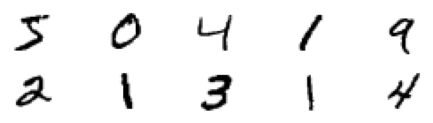

In [32]:
# Визуализируем данные
X_ = X.values
y_ = y.to_numpy(dtype = 'int')
_, axes = plt.subplots(nrows = 2, ncols = 5, figsize=(8, 2))

for ax, image in zip(axes.flatten(), X_):
    ax.set_axis_off()
    ax.imshow(image.reshape((28, 28)), cmap = plt.cm.gray_r)

In [33]:
# Определим количество пустых строк.
A = X.isnull().mean() * 100
i = 0
n = 0
while i < len(A):
    if A[i] != 0:
        print(A[i])
        i += 1
        n += 1
    else:
        i+=1
if n == 0:
    print('Все элементы заполнены.')

Все элементы заполнены.


In [34]:
data = X
data['y'] = y

# Удалим одинаковые строки.
data_ = data.drop_duplicates(keep = 'first')
if data.shape == data_.shape:
    print('Повторяющихся строк нет.')

Повторяющихся строк нет.


In [35]:
X__ = X_
y__ = y_

[5 0 4 ... 2 1 2]


In [36]:
# Aлгоритм TruncatedSVD
# Начальные параметры
aggclust = AgglomerativeClustering(n_clusters = 10)
clusters_AC = aggclust.fit_predict(X__)
d_vs_AC = 784
v_score_AC_max = v_measure_score(y__, clusters_AC)
silhouette_score_AC_max = silhouette_score(X__, clusters_AC)

kmeans = KMeans(n_clusters = 10, n_init = 100)
clusters_KM = kmeans.fit_predict(X__)
d_vs_KM = 784
v_score_KM_max = v_measure_score(y__, clusters_KM)
silhouette_score_AC_max = silhouette_score(X__, clusters_KM)

In [302]:
# Поиск лучших параметров.
for n_components in (2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500,600,700):
    T_svd = TruncatedSVD(n_components = n_components, random_state = 20)
    X_new = T_svd.fit_transform(X__)
    
    # Иерархическая кластеризация
    aggclust = AgglomerativeClustering(n_clusters = 10)
    clusters_AC = aggclust.fit_predict(X_new)
     
    if silhouette_score_AC_max < silhouette_score(X_new, clusters_AC):
        silhouette_score_AC_max = silhouette_score(X_new, clusters_AC)
        d_ss_AC = n_components
        
    if v_score_AC_max < v_measure_score(y__, clusters_AC):
        v_score_AC_max = v_measure_score(y__, clusters_AC)
        d_vs_AC = n_components
        
    # К-средних
    kmeans = KMeans(n_clusters = 10, n_init = 100)
    clusters_KM = kmeans.fit_predict(X_new)
    
    if silhouette_score_KM_max < silhouette_score(X_new, clusters_KM):
        silhouette_score_KM_max = silhouette_score(X_new, clusters_KM)
        d_ss_KM = n_components
        
    if v_score_KM_max < v_measure_score(y__, clusters_KM):
        v_score_KM_max = v_measure_score(y__, clusters_KM)
        d_vs_KM = n_components

In [303]:
V_measure_score_AC_svd = v_score_AC_max
V_measure_score_KM_svd = v_score_KM_max

if V_measure_score_AC_svd > V_measure_score_KM_svd:
    V_measure_score_svd = V_measure_score_AC_svd
    d_vs_svd = d_vs_AC
    clast_vs_svd = 'Иерархическая кластеризация'
    clastering_best_vs_svd = AgglomerativeClustering(n_clusters = 10)
else:
    V_measure_score_svd = V_measure_score_KM_svd
    d_vs_svd = d_vs_KM
    clast_vs_svd = 'К-средних кластеризация'
    clastering_best_vs_svd = KMeans(n_clusters = 10, n_init = 100)
    
print('Максисум V-меры  = ', V_measure_score_svd, 'достигается при количестве признаков ' , d_vs_svd, '.', clast_vs_svd)

    
silhouette_score_AC_svd = silhouette_score_AC_max
silhouette_score_KM_svd = silhouette_score_KM_max

if silhouette_score_AC_svd > silhouette_score_KM_svd:
    silhouette_score_svd = silhouette_score_AC_svd
    d_ss_svd = d_vs_AC
    clast_ss_svd = 'Иерархическая кластеризация'
    clastering_best_ss_svd = AgglomerativeClustering(n_clusters = 10)
else:
    silhouette_score_svd = silhouette_score_KM_svd
    d_ss_svd = d_vs_KM
    clast_ss_svd = 'К-средних кластеризация'
    clastering_best_ss_svd = KMeans(n_clusters = 10, n_init = 100)
print('Максисум силуэта  = ', silhouette_score_svd, 'достигается при количестве признаков ' , d_ss_svd, '.', clast_ss_svd)

Максисум V-меры  =  0.6974153690092375 достигается при количестве признаков  600 . Иерархическая кластеризация
Максисум силуэта  =  0.6459219 достигается при количестве признаков  300 . К-средних кластеризация


In [304]:
# TSNE-преобразование

# Начальные параметры
aggclust = AgglomerativeClustering(n_clusters = 10)
clusters_AC = aggclust.fit_predict(X__)
silhouette_score_AC_max = silhouette_score(X__, clusters_AC)
v_score_AC_max = v_measure_score(y__, clusters_AC)

kmeans = KMeans(n_clusters = 10, n_init = 100)
clusters_KM = kmeans.fit_predict(X__)
silhouette_score_KM_max = silhouette_score(X__, clusters_KM)
v_score_KM_max = v_measure_score(y__, clusters_KM)

In [305]:
# Поиск лучших параметров.
for n_components in (2, 3):
    X_tsne = TSNE(n_components = n_components, random_state = 20).fit_transform(X__)
    
    # Иерархическая кластеризация
    aggclust = AgglomerativeClustering(n_clusters = 10)
    clusters_AC = aggclust.fit_predict(X_tsne)

    if silhouette_score_AC_max < silhouette_score(X_tsne, clusters_AC):
        silhouette_score_AC_max = silhouette_score(X_tsne, clusters_AC)
        d__ss_AC = n_components
    
    if v_score_AC_max < v_measure_score(y__, clusters_AC):
        v_score_AC_max = v_measure_score(y__, clusters_AC)
        d__vs_AC = n_components 
        
    # К-средних
    kmeans = KMeans(n_clusters = 10, n_init = 100)
    clusters_KM = kmeans.fit_predict(X_tsne)

    if silhouette_score_KM_max < silhouette_score(X_tsne, clusters_KM):
        silhouette_score_KM_max = silhouette_score(X_tsne, clusters_KM)
        d__ss_KM = n_components
        
    if v_score_KM_max < v_measure_score(y__, clusters_KM):
        v_score_KM_max = v_measure_score(y__, clusters_KM)
        d__vs_KM = n_components
        

In [306]:
V_measure_score_AC_tsne = v_score_AC_max
V_measure_score_KM_tsne = v_score_KM_max

if V_measure_score_AC_tsne > V_measure_score_KM_tsne:
    V_measure_score_tsne = V_measure_score_AC_tsne
    d_vs_tsne = d__vs_AC
    clast_vs_tsne = 'Иерархическая кластеризация'
    clastering_best_vs_tsne = AgglomerativeClustering(n_clusters = 10)
else:
    V_measure_score_tsne = V_measure_score_KM_tsne
    d_vs_tsne = d__vs_KM
    clast_vs_tsne = 'К-средних кластеризация'
    clastering_best_vs_tsne = KMeans(n_clusters = 10, n_init = 100)
    
print('Максисум V-меры  = ', V_measure_score_tsne, 'достигается при количестве признаков ' , d_vs_tsne, '.', clast_vs_tsne)

silhouette_score_AC_tsne = silhouette_score_AC_max
silhouette_score_KM_tsne = silhouette_score_KM_max

if silhouette_score_AC_tsne > silhouette_score_KM_tsne:
    silhouette_score_tsne = silhouette_score_AC_tsne
    d_ss_tsne = d__vs_AC
    clast_ss_tsne = 'Иерархическая кластеризация'
    clastering_best_ss_tsne = AgglomerativeClustering(n_clusters = 10)
else:
    silhouette_score_tsne = silhouette_score_KM_tsne
    d_ss_tsne = d__vs_KM
    clast_ss_tsne = 'К-средних кластеризация'
    clastering_best_ss_tsne = KMeans(n_clusters = 10, n_init = 100)
    
print('Максисум силуэта  = ', silhouette_score_tsne, 'достигается при количестве признаков ' , d_ss_tsne, '.', clast_ss_tsne)

Максисум V-меры  =  0.8249508194626358 достигается при количестве признаков  3 . Иерархическая кластеризация
Максисум силуэта  =  0.41512963 достигается при количестве признаков  3 . К-средних кластеризация


In [326]:
# Количество классов n_clusters = 10
# Определим количество признаков n_components и метод кластеризации(при оценивании v-меры):
if V_measure_score_svd > V_measure_score_tsne:
    T_svd = TruncatedSVD(n_components = d_vs_svd, random_state = 20)
    X_svd = T_svd.fit_transform(X__)
    clusters = clastering_best_vs_svd.fit_predict(X_new) 
    print('Максисум V-меры  = ', V_measure_score_svd, 'достигается при количестве признаков ' , d_vs_svd, '.', clast_vs_svd)
else:
    X_tsne = TSNE(n_components = d_vs_tsne, random_state = 20).fit_transform(X__)
    clusters = clastering_best_vs_tsne.fit_predict(X_new)
    print('Максисум V-меры  = ', V_measure_score_tsne, 'достигается при количестве признаков ' , d_vs_tsne, '.', clast_vs_tsne)

Максисум V-меры  =  0.8249508194626358 достигается при количестве признаков  3 . Иерархическая кластеризация


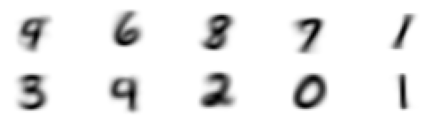

In [327]:
# Визуализация лучшей модели для найлучшего значения V-меры.

centers_ = centres(clusters, X__)

fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize=(8, 2))
for ax, center in zip(ax.flat, centers_):
    ax.set_axis_off()
    ax.imshow(center.reshape(28, 28),  cmap = plt.cm.gray_r)

In [314]:
# Количество классов n_clusters = 10
# Определим количество признаков n_components и метод кластеризации(при оценивании силуэта):    
if silhouette_score_svd > silhouette_score_tsne:
    T_svd = TruncatedSVD(n_components = d_ss_svd, random_state = 20)
    X_svd = T_svd.fit_transform(X__)
    clusters = clastering_best_ss_svd.fit_predict(X_new) 
    print('Максисум силуэта  = ', silhouette_score_svd, 'достигается при количестве признаков ' , d_ss_svd, '.', clast_ss_svd)
else:
    X_tsne = TSNE(n_components = d_ss_tsne, random_state = 20).fit_transform(X__)
    clusters = clastering_best_ss_tsne.fit_predict(X_new)
    print('Максисум силуэта  = ', silhouette_score_tsne, 'достигается при количестве признаков ' , d_ss_tsne, '.', clast_ss_tsne)

Максисум силуэта  =  0.6459219 достигается при количестве признаков  300 . К-средних кластеризация


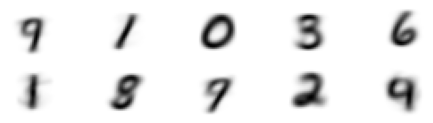

In [325]:
# Визуализация лучшей модели для найлучшего значения силуэта.

centers_ = centres(clusters, X__)

fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize=(8, 2))
for ax, center in zip(ax.flat, centers_):
    ax.set_axis_off()
    ax.imshow(center.reshape(28, 28),  cmap = plt.cm.gray_r)